In [1]:
import os
import time
import pickle
from multiprocessing import Pool
import itertools

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler


os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200


In [3]:
@np.vectorize
def bgs_rec(mu, s, r, L):
    return np.exp(-L * mu/(s*(1+(1-s)*r/s)**2))

## Data

In [36]:
with open('../msprime_sims/bgs_rec_1rep_2.pkl', 'rb') as f:
    params, bhats = pickle.load(f)
X = np.array(params)
#y = np.log10(np.array(bhats).mean(axis=1))
#y = np.log10(np.array(bhats))
y = np.array(bhats)

In [37]:
# 0   1  2  3  4  5
# mu  s  r  N  L  nreps

X_train, X_test, y_train, y_test = train_test_split(X[:, (0, 1, 2, 3, 4)], y,  test_size=0.10, random_state=1)
X_scaler = StandardScaler().fit(X_train)
X_train_normalized = X_scaler.transform(X_train)

In [38]:
X_train.min(axis=0), X_train.max(axis=0), 

(array([1.00000327e-08, 1.00001324e-03, 1.00000122e-09, 5.00005523e+01,
        1.04334665e+01]),
 array([9.99998314e-08, 9.99997954e-02, 9.99987631e-08, 9.99972198e+04,
        9.99999441e+04]))

In [39]:
X_test_normalized = X_scaler.transform(X_test)

In [89]:
def network():
    # build network
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(5,)))
    #model.add(layers.BatchNormalization(axis=1))
    for i in range(4):
        model.add(layers.Dense(64, activation='elu'))
        #model.add(layers.Dropout(0.2))
    for i in range(2):
        model.add(layers.Dense(32, activation='elu'))
        #model.add(layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer='Adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['MeanAbsoluteError'],
        )
    return model

In [90]:
model = network()
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                   patience=50, restore_best_weights=True)
history = model.fit(X_train_normalized, y_train, 
                    validation_split=0.2, 
                    #validation_data=(X_test_normalized, y_test),
                    batch_size=1_000, epochs=500, verbose=0, callbacks=[es])

Restoring model weights from the end of the best epoch: 149.
Epoch 00199: early stopping


In [91]:
predict = model.predict(X_test_normalized)

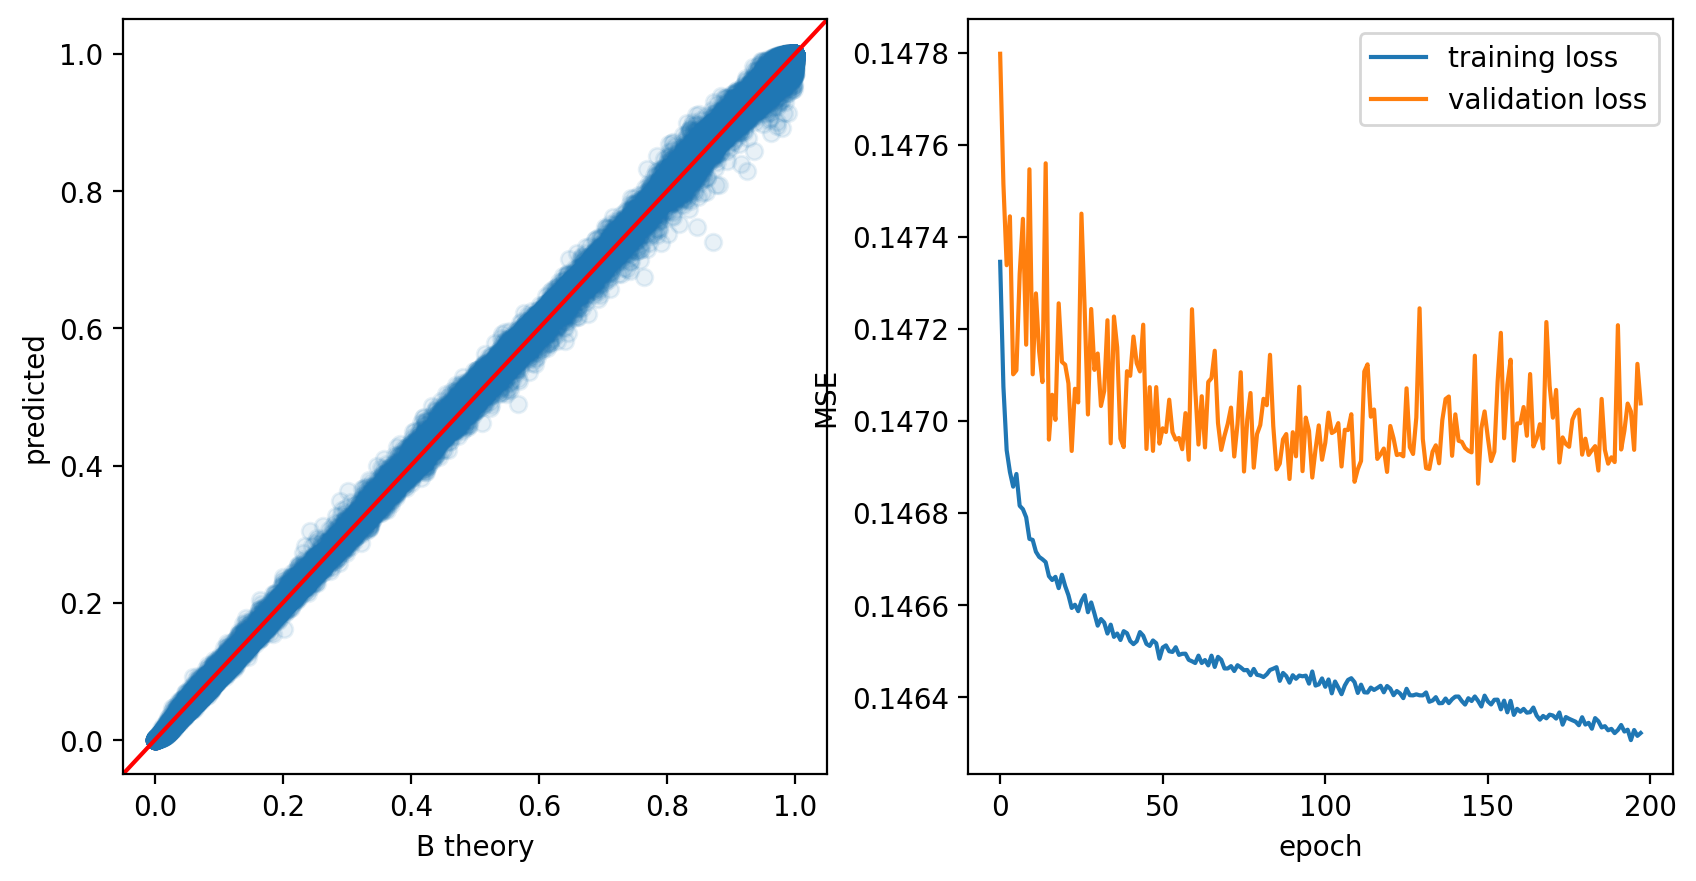

In [94]:
y_theory = bgs_rec(X_test[:, 0], X_test[:, 1], X_test[:, 2], X_test[:, 4])


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#ax1.scatter(X_test[:, 0]/X_test[:, 1], y_test)
ax1.scatter(y_theory, predict, alpha=0.1)
ax1.axline((0, 0), slope=1, c='r')
ax2.plot(history.history['loss'][1:], label='training loss')
ax2.plot(history.history['val_loss'][1:], label='validation loss')
ax2.set_ylabel("MSE")
ax2.set_xlabel("epoch")
ax1.set_xlabel("B theory")
ax1.set_ylabel("predicted")
#ax2.set_ylim((0, 1))
ax2.legend()

In [61]:
model.evaluate(X_test_normalized, y_test)

3125/3125 [==============================] - 6s 2ms/step - loss: 0.1446 - mean_absolute_error: 0.2684


[0.14460912346839905, 0.26843932271003723]

In [55]:
model.evaluate(X_test_normalized, y_test)

3125/3125 [==============================] - 5s 2ms/step - loss: 0.1446 - mean_absolute_error: 0.2683


[0.1446310430765152, 0.2682616710662842]

In [95]:
np.abs(predict.flatten() - y_test.flatten()).mean(), np.abs(predict.flatten() - y_theory.flatten()).mean()

(0.26878519360757114, 0.007151165998975198)

In [56]:
np.abs(predict.flatten() - y_test.flatten()).mean(), np.abs(predict.flatten() - y_theory.flatten()).mean()

(0.26826146703124454, 0.0076540358585502006)

Text(0, 0.5, 'B')

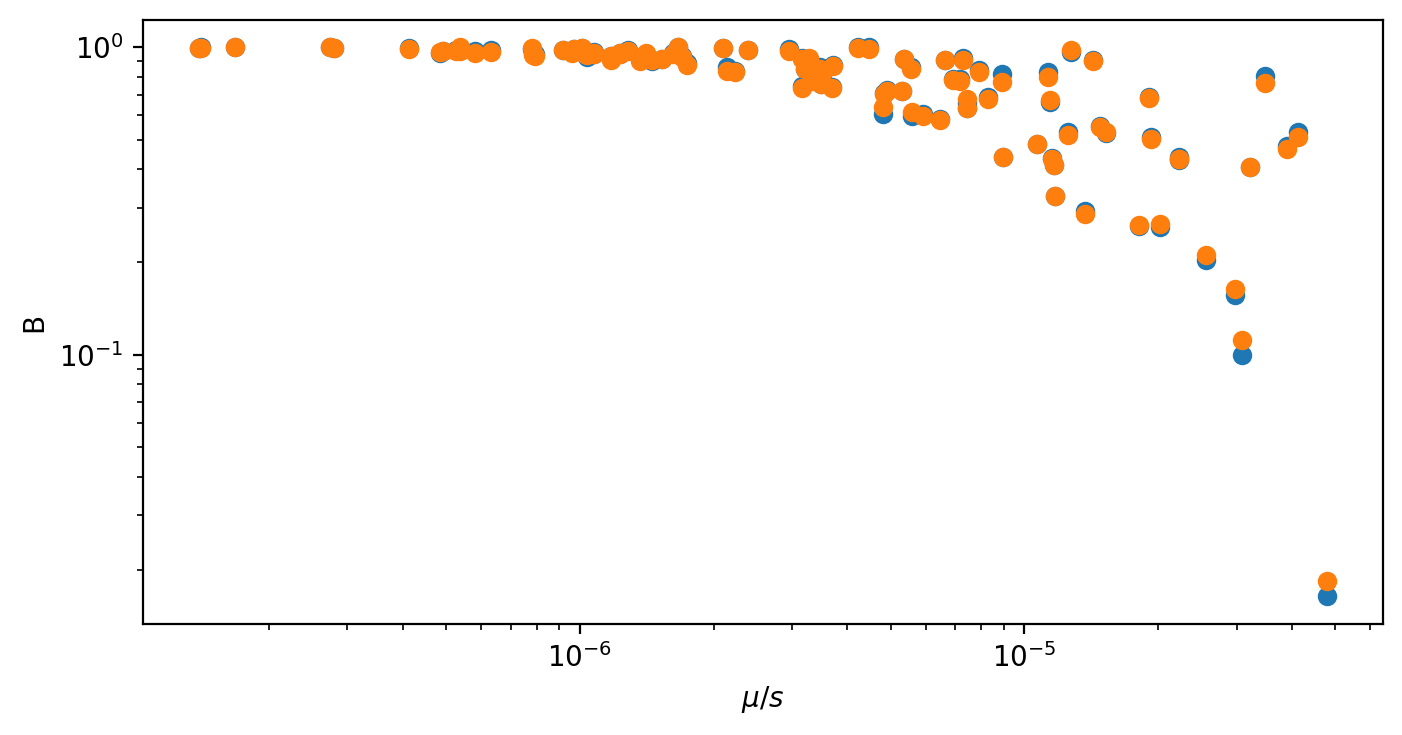

In [104]:
n = 100
mu = 10**np.random.uniform(-8, -7, n)
s = 10**np.random.uniform(-3, -1, n)
rbp = 10**np.random.uniform(-8, -9, n)
L = np.random.uniform(10, 100_000, n)
N = np.random.uniform(50, 100_000, n)
xnew = np.array((mu, s, rbp, N, L)).T
rate = xnew[:, 0]/xnew[:, 1]
fig, ax = plt.subplots()
ax.scatter(rate, model.predict(X_scaler.transform(xnew)))
ax.scatter(rate, bgs_rec(mu, s, rbp, L))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mu/s$')
ax.set_ylabel('B')

In [105]:
tf.reduce_mean(np.abs(predict.flatten() - y_theory.flatten()))

<tf.Tensor: shape=(), dtype=float64, numpy=0.007151165998975198>

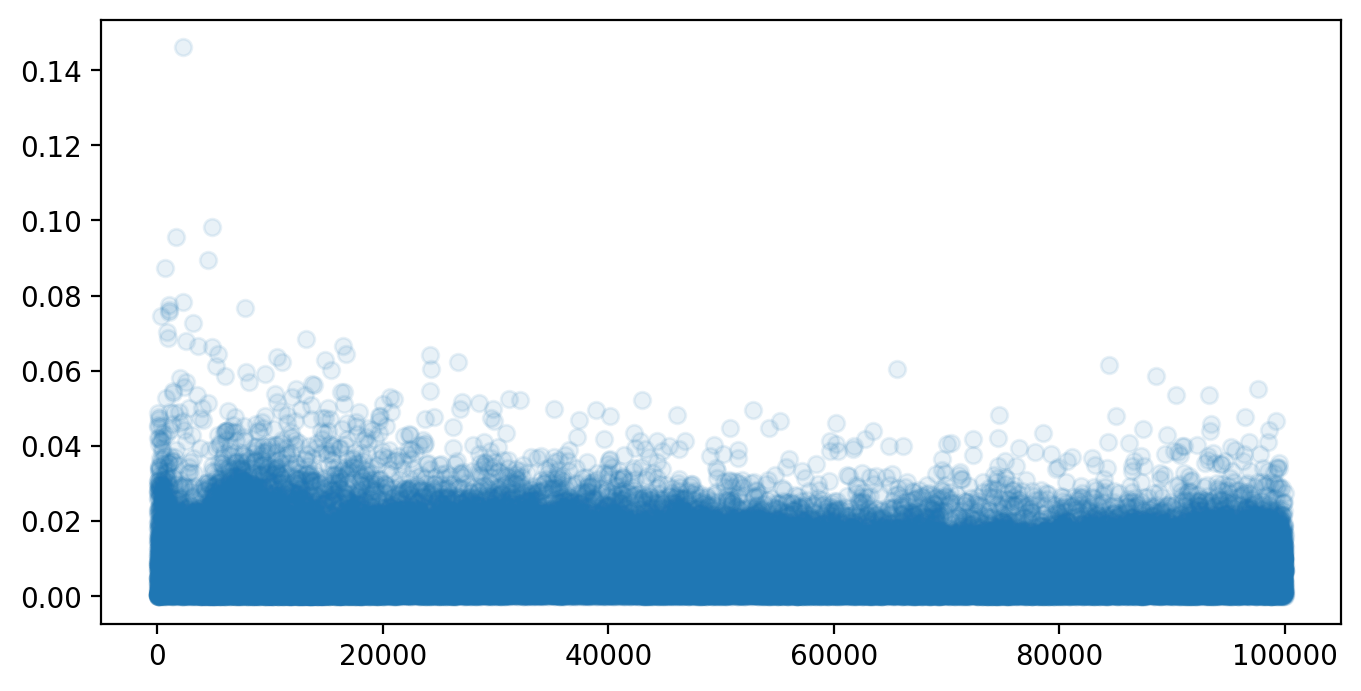

In [112]:
plt.scatter(X_test[:, 4], np.abs(predict.flatten() - y_theory.flatten()), alpha=0.1)